# Pseudo-biases with vector velocities

Investigate pseudo-biases in vector velocity / magnitude data. Pseudo-biases are biases that are not characteristigs of the observations, but arise from the non-linear transformation from vector components to vector velocity / magnitude.

Consider a vector field with components $(dX,dY)$. The true vector ield is $T=(tX,tY)$, with observations $O=(oX,oY)$. $oX$ (resp. $oY$) are un-biased observations of $tX$ (resp. $tY$) with uncertainties $uX$ and $uY$.

We will see that, despite $oX$ and $oY$ being un-biased observations, the observed velocity $oV = \sqrt{oX^2+oY^2}$ is biased *wrt* the true velocity $tV = \sqrt{tX^2+tY^2}$.

Inspired / adapted from Appendix B of Stoffelen (1998).

Stoffelen, A. (1998), Toward the true near-surface wind speed: Error modeling and calibration using triple collocation, J. Geophys. Res., 103( C4), 7755– 7766, doi:10.1029/97JC03180.

In [1]:
import numpy as np
from numpy.random import default_rng
from matplotlib import pylab as plt
import matplotlib.lines as mlines

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

In [2]:
rng = default_rng()
N = 5000

def velocity(dX, dY):
    return (dX**2 + dY**2)**0.5

## Illustration of the pseudo-bias

Define the (unknown) truth for $dX$, $dY$, and velocity

In [3]:
sig_t = 17.
tX = rng.standard_normal(N) * sig_t + 5.4
tY = rng.standard_normal(N) * sig_t + 2.1
tV = velocity(tX, tY)

Define an un-biased observation of the truth, with uncertainties

In [4]:
# uncertain observations of dX
sig_ux = 10
ux = rng.standard_normal(N) * sig_ux
oX = tX + ux

# uncertain observations of dY
sig_uy = 10
uy = rng.standard_normal(N) * sig_uy
oY = tY + uy

# observation of the velocity (derived from oX and oY)
oV = velocity(oX, oY)

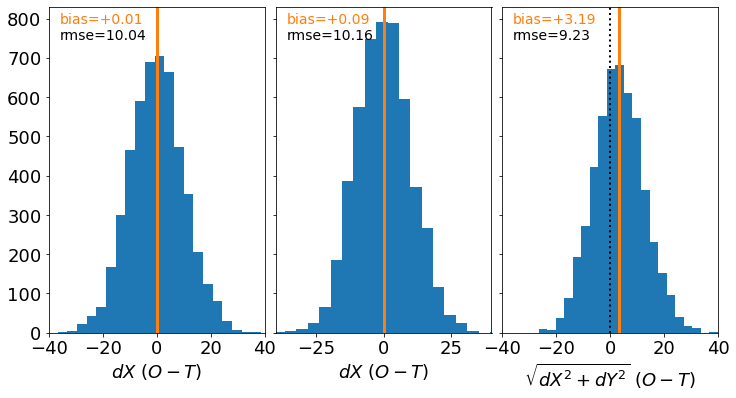

In [5]:

def plot_hist(ax, d, w, maxu):
    ax.hist(d, bins=21)
    ax.set_xlabel(w + r" $(O-T)$")
    ax.set_xlim(-maxu,+maxu)
    ax.axvline(x=0, color='k', ls=':', lw=2)
    bias = d.mean()
    rmse = d.std()
    ax.axvline(x=bias, color='C1', ls='-', lw=3)
    fs = 14
    ystep = 0.05
    ystart = 0.95
    ax.text(0.05,ystart,'bias={:+.2f}'.format(bias),transform=ax.transAxes, fontsize=fs, color='C1'); ystart -= ystep
    ax.text(0.05,ystart,'rmse={:.2f}'.format(rmse),transform=ax.transAxes, fontsize=fs); ystart -= ystep
    
maxu = 4*max(sig_ux,sig_uy)
fig = plt.figure(figsize=(12,6))

ax = fig.add_subplot(1,3,1)
plot_hist(ax, oX - tX, r"$dX$", maxu)

ax = fig.add_subplot(1,3,2,sharey=ax)
plot_hist(ax, oY - tY, r"$dX$", maxu)
plt.setp(ax.get_yticklabels(), visible=False)

ax = fig.add_subplot(1,3,3,sharey=ax)
plot_hist(ax, oV - tV, r"$\sqrt{dX^2+dY^2}$", maxu)
plt.setp(ax.get_yticklabels(), visible=False)

plt.subplots_adjust(wspace=0.05)
plt.show()

We see that, despite  $oX$  and  $oY$  are un-biased observations of $tX$ and $tY$, the resulting observed velocity $oV$ (computed from $oX$ and $oY$) is biased *wrt* the true velocity $tV$.

## Implication for trend analysis

Create an artificial timeseries of $tX$ and $tY$, with some trends. $tX$ and $tY$ are the mean values of two distributions whose standard deviation $\sigma_t$ stays constant.

In [6]:
years = np.arange(1979,2021).astype('int')
aX = np.ones(len(years)) * (years - years[0]) * 0.05 + 0.5
aY = np.ones(len(years)) * (years - years[0]) * 0.09 - 1.0

Consider an un-biased obsevation system with uncertainties that improve in two jumps (e.g. better technologies). The uncertainty is the same for $dX$ and $dY$. 

In [7]:
sig_os = 4 * np.ones(len(years))
sig_os[(years>=1987)*(years<2002)]  = 3
sig_os[(years>=2002)]  = 2

Go through the years, simulate true and observed distribution of the components, then compute the velocities, finally compute the yearly averaged values of all these quantities.

In [8]:
tX = np.zeros(len(years))
tY = np.zeros(len(years))
tV = np.zeros(len(years))
oX = np.zeros(len(years))
oY = np.zeros(len(years))
oV = np.zeros(len(years))
for y in range(len(years)):
    # distribution of tXs and tYs
    tXs = rng.standard_normal(N) * 4 + aX[y]
    tYs = rng.standard_normal(N) * 4 + aY[y]
    # corresponding tVs
    tVs = velocity(tXs, tYs)
    # simulate the oXs and oYs
    ux = rng.standard_normal(N) * sig_os[y]
    oXs = tXs + ux
    uy = rng.standard_normal(N) * sig_os[y]
    oYs = tYs + uy
    #corresponding oVs
    oVs = velocity(oXs, oYs)
    # extract yearly averages
    tX[y] = tXs.mean()
    tY[y] = tYs.mean()
    tV[y] = tVs.mean()
    oX[y] = oXs.mean()
    oY[y] = oYs.mean()
    oV[y] = oVs.mean()

from scipy.stats import linregress
alpha_tV, beta_tV, _, _, _ = linregress(years, tV)
alpha_oV, beta_oV, _, _, _ = linregress(years, oV)

Plotting

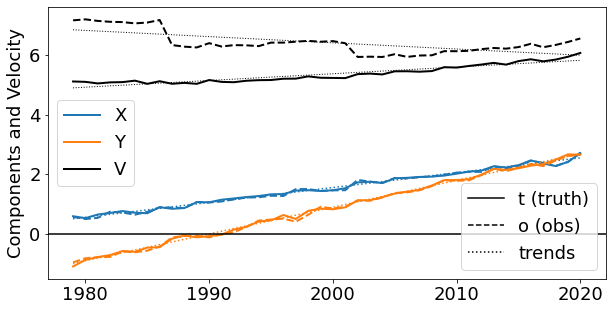

In [9]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)

ax.plot(years, tX, label='X', c='C0', lw=2)
ax.plot(years, oX, c='C0', lw=2, ls='--')
ax.plot(years, aX, c='C0', ls=':' )

ax.plot(years, tY, label='Y', c='C1', lw=2)
ax.plot(years, oY, c='C1', lw=2, ls='--')
ax.plot(years, aY, c='C1', ls=':' )

ax.plot(years, tV, 'k-', label='V', lw=2)
ax.plot(years, oV, 'k--', lw=2)
ax.plot(years, alpha_tV*years + beta_tV, 'k:', lw=1)
ax.plot(years, alpha_oV*years + beta_oV, 'k:', lw=1)

ax.axhline(y=0, color='k', ls='-')

line1 = mlines.Line2D([], [], color='k', ls = '-', label='t (truth)')
line2 = mlines.Line2D([], [], color='k', ls = '--', label='o (obs)')
line3 = mlines.Line2D([], [], color='k', ls = ':', label='trends')
sec_leg = ax.legend(handles=[line1,line2,line3], loc='lower right')
ax.add_artist(sec_leg,)

ax.set_ylabel('Components and Velocity')
ax.legend(loc='center left')
plt.show()

We observe that the $oX$ and $oY$ follow $tX$ and $tY$: they are un-biased observations of the truth and follow the actual trends.

Converserly, $oV$ is very different from $tV$. First, we observe that $oV$ is systematically larger than $tV$, which is due to the pseudo-bias following the propagation of the observation uncertainty in the non-linear transform from the components to the velocity.

In addition, we observe jumps in $oV$. These jumps correspond to the changing observation uncertainties along the timeseries (e.g. technological improvements with better satellites). Note that these jumps are not visible in $oX$ and $oY$: they do not impact the mean observed value (since the observations of components remain un-biased).

The jumps in $oV$ even result in an overall negative trend in observed velocity while the trend of the true velocity is positive.

## Conclusion
Be cautious with velocities (and generally non-linear transforms) in case of observational uncertainties: they introduce pseudo-biases, jumps in timeseries, and can result in erroneous trends. Always first compare vector timeseries in terms of their components.